In [1]:
import keras
import tensorflow as tf

In [2]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
from keras_unet.models import custom_unet, satellite_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import plot_segm_history

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
# training data subset original for first 60
base_dirO = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\data_256\train')
mask_dirO = base_dirO.joinpath('80s_mask')
train_image_dirO = mask_dirO.joinpath('u_train_reproject')
trees_mask_dirO = mask_dirO.joinpath('trees')
building_mask_dirO = mask_dirO.joinpath('building')
pavement_mask_dirO = mask_dirO.joinpath('pavement')

In [4]:
os.listdir(mask_dirO)

['building', 'desktop.ini', 'pavement', 'trees', 'u_train_reproject']

In [5]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [6]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [7]:
# crop image at pixel 75 x 75 (ignoring NA extent created by reprojection)
def load_image_large(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()[81:209,81:209]

In [8]:
209-81

128

In [9]:
def sorted_paths(img_dir: Path):
    return sorted(glob(img_dir.joinpath('*.tif').as_posix()), key=img_number)

In [10]:
def load_stack_safely_large(shape, dtype, img_dir, prefix):
    """
    Load a stack of images from disk into an ndarray.

    Performs the load potentially several times, to ensure that values
    stabilize. Google seems to be...tricky...
    """
    last_sum = 0
    while True:
        stack = np.zeros(shape=shape, dtype=dtype)
        for i in range(shape[0]):
            image_path = make_path(img_dir, prefix, i + 1)
            if not os.path.isfile(image_path):
                print("skipping", image_path)
                continue
            stack[i, :, :] = load_image_large(image_path)
        if stack.sum() == last_sum:
            break
        last_sum = stack.sum()
    return stack

In [11]:
I, N, M = 60, 128, 128

In [12]:
train_imagesO = load_stack_safely_large((I, N, M), np.float32, train_image_dirO, "wgs_train")
tree_masksO = load_stack_safely_large((I, N, M), np.int8, trees_mask_dirO, "tree_mask")
building_masksO = load_stack_safely_large((I, N, M), np.int8, building_mask_dirO, "building_mask")
pavement_masksO = load_stack_safely_large((I, N, M), np.int8, pavement_mask_dirO, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_13.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_22.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_41.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_13.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_22.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\trees\tree_mask_41.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\building\building_mask_1.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\building\building_mask_8.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\train\80s_mask\bui

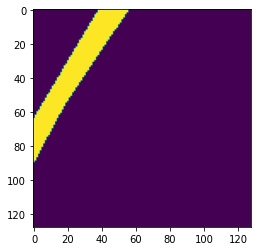

In [15]:
plt.imshow(pavement_masksO[5,:,:])

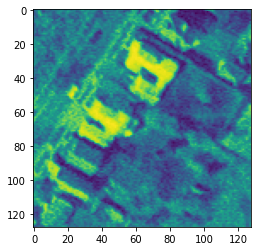

In [16]:
plt.imshow(train_imagesO[5,:,:])

In [35]:
# Use small traced images for last 40
base_dirS = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\data_128\train')
mask_dirS = base_dirS.joinpath('mask')
train_image_dirS = mask_dirS.joinpath('u_train_reproject')
trees_mask_dirS = mask_dirS.joinpath('trees')
building_mask_dirS = mask_dirS.joinpath('building')
pavement_mask_dirS = mask_dirS.joinpath('pavement')

In [55]:
def load_image_small(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()[7:-7,5:-5]

In [56]:
test = load_image_small(r'e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\u_train_reproject\wgs_train_40.tif')

In [57]:
test2 = load_image_small(r'e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_1.tif')

In [58]:
test2.shape

(128, 128)

In [59]:
test.shape

(128, 128)

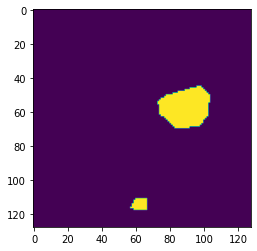

In [60]:
plt.imshow(test2)

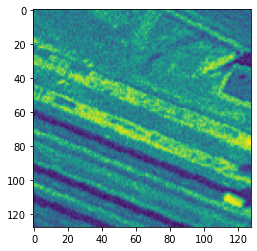

In [61]:
plt.imshow(test)

In [21]:
test.shape

(128, 128)

In [62]:
def load_stack_safely_small(shape, dtype, img_dir, prefix):
    """
    Load a stack of images from disk into an ndarray.

    Performs the load potentially several times, to ensure that values
    stabilize. Google seems to be...tricky...
    """
    last_sum = 0
    while True:
        stack = np.zeros(shape=shape, dtype=dtype)
        for i in range(shape[0]):
            image_path = make_path(img_dir, prefix, i + 1 )
            if not os.path.isfile(image_path):
                print("skipping", image_path)
                continue
            stack[i, :, :] = load_image_small(image_path)
        if stack.sum() == last_sum:
            break
        last_sum = stack.sum()
    return stack

In [65]:
K, N, M = 40, 128, 128
train_imagesS = load_stack_safely_small((K, N, M), np.float32, train_image_dirS, "wgs_train")
tree_masksS = load_stack_safely_small((K, N, M), np.int8, trees_mask_dirS, "tree_mask")
building_masksS = load_stack_safely_small((K, N, M), np.int8, building_mask_dirS, "building_mask")
pavement_masksS = load_stack_safely_small((K, N, M), np.int8, pavement_mask_dirS, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_2.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_5.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_7.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_9.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_10.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_12.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_14.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_15.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_128\train\mask\trees\tree_mask_16.tif
skipping e:\Google Drive\researc

In [66]:
train_images = np.zeros((100,128,128))
tree_masks =  np.zeros((100,128,128))
building_masks =  np.zeros((100,128,128))
pavement_masks =  np.zeros((100,128,128))


In [67]:
train_images[0:60,:,:] = train_imagesO
train_images[60:100,:,:] = train_imagesS

In [68]:
tree_masks[0:60,:,:] = tree_masksO
tree_masks[60:100,:,:] = tree_masksS

In [69]:
building_masks[0:60,:,:] = building_masksO
building_masks[60:100,:,:] = building_masksS

In [70]:
pavement_masks[0:60,:,:] = pavement_masksO
pavement_masks[60:100,:,:] = pavement_masksS

In [71]:

def load_image_no_trim(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()

In [72]:
def load_stack_nt(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape=shape, dtype=dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        stack[i, :, :] = load_image_no_trim(image_path)
    return stack

In [73]:
N,M

(128, 128)

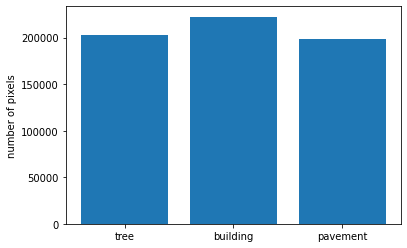

In [74]:
fig, ax = plt.subplots()
ax.bar(range(3), [tree_masks.sum(), building_masks.sum(), pavement_masks.sum()])
ax.set_xticks((0, 1, 2))
ax.set_xticklabels(('tree', 'building', 'pavement'))
plt.ylabel('number of pixels')
plt.show()

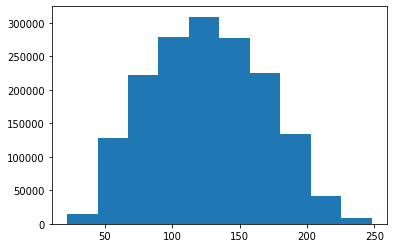

In [75]:
plt.hist(train_images.flatten())
plt.show()

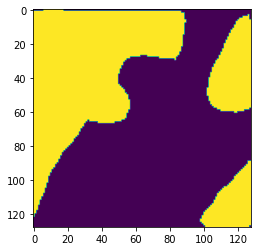

In [77]:
plt.imshow(tree_masks[89,:,:])

In [78]:
model = satellite_unet(
    (N, M, 1),
    3,
    # dropout_type="spatial"
)

In [79]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded],
    
)

In [80]:
W = 100
Y = np.zeros(shape=(W, N, M, 3), dtype=np.int8)
Y[:, :, :, 0] = tree_masks
Y[:, :, :, 1] = building_masks
Y[:, :, :, 2] = pavement_masks

In [81]:
Y.shape, tree_masks.shape

((100, 128, 128, 3), (100, 128, 128))

In [82]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [83]:
checkpoint_path = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save')
checkpoint_dir = os.path.dirname(checkpoint_path)

In [84]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [85]:
history = model.fit(
    train_images.reshape(W, N, M, 1),
    Y,
    epochs=150,
          callbacks=[cp_callback])

Epoch 1/150
4/4 [==============================] - ETA: 0s - loss: 0.7045 - iou: 0.1284 - iou_thresholded: 0.1212
Epoch 00001: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 16s 3s/step - loss: 0.7045 - iou: 0.1284 - iou_thresholded: 0.1212
Epoch 2/150
4/4 [==============================] - ETA: 0s - loss: 0.4326 - iou: 0.1017 - iou_thresholded: 0.0616
Epoch 00002: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 13s 3s/step - loss: 0.4326 - iou: 0.1017 - iou_thresholded: 0.0616
Epoch 3/150
4/4 [==============================] - ETA: 0s - loss: 0.3829 - iou: 0.1094 - iou_thresholded: 0.0539
Epoch 00003: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 13s 3s/step - loss: 0.3829 - iou: 0.1094 - iou_thresholded: 0.0539
Epoc

4/4 [==============================] - 14s 3s/step - loss: 0.2878 - iou: 0.1972 - iou_thresholded: 0.2057
Epoch 26/150
4/4 [==============================] - ETA: 0s - loss: 0.2970 - iou: 0.2096 - iou_thresholded: 0.2325
Epoch 00026: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 14s 3s/step - loss: 0.2970 - iou: 0.2096 - iou_thresholded: 0.2325
Epoch 27/150
4/4 [==============================] - ETA: 0s - loss: 0.2759 - iou: 0.2101 - iou_thresholded: 0.2167
Epoch 00027: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 15s 3s/step - loss: 0.2759 - iou: 0.2101 - iou_thresholded: 0.2167
Epoch 28/150
4/4 [==============================] - ETA: 0s - loss: 0.2752 - iou: 0.2250 - iou_thresholded: 0.2534
Epoch 00028: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4

4/4 [==============================] - ETA: 0s - loss: 0.1801 - iou: 0.3461 - iou_thresholded: 0.4433
Epoch 00050: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 14s 3s/step - loss: 0.1801 - iou: 0.3461 - iou_thresholded: 0.4433
Epoch 51/150
4/4 [==============================] - ETA: 0s - loss: 0.1846 - iou: 0.3610 - iou_thresholded: 0.4329
Epoch 00051: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 13s 3s/step - loss: 0.1846 - iou: 0.3610 - iou_thresholded: 0.4329
Epoch 52/150
4/4 [==============================] - ETA: 0s - loss: 0.1893 - iou: 0.3341 - iou_thresholded: 0.4212
Epoch 00052: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 13s 3s/step - loss: 0.1893 - iou: 0.3341 - iou_thresholded: 0.4212
Epoch 53/150
4

4/4 [==============================] - 14s 3s/step - loss: 0.2220 - iou: 0.3189 - iou_thresholded: 0.3940
Epoch 75/150
4/4 [==============================] - ETA: 0s - loss: 0.2088 - iou: 0.3060 - iou_thresholded: 0.3577
Epoch 00075: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 14s 3s/step - loss: 0.2088 - iou: 0.3060 - iou_thresholded: 0.3577
Epoch 76/150
4/4 [==============================] - ETA: 0s - loss: 0.1918 - iou: 0.3088 - iou_thresholded: 0.4229
Epoch 00076: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 14s 3s/step - loss: 0.1918 - iou: 0.3088 - iou_thresholded: 0.4229
Epoch 77/150
4/4 [==============================] - ETA: 0s - loss: 0.1911 - iou: 0.3322 - iou_thresholded: 0.4003
Epoch 00077: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4

4/4 [==============================] - ETA: 0s - loss: 0.1213 - iou: 0.5308 - iou_thresholded: 0.6527
Epoch 00099: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 13s 3s/step - loss: 0.1213 - iou: 0.5308 - iou_thresholded: 0.6527
Epoch 100/150
4/4 [==============================] - ETA: 0s - loss: 0.1267 - iou: 0.4921 - iou_thresholded: 0.6047
Epoch 00100: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 14s 3s/step - loss: 0.1267 - iou: 0.4921 - iou_thresholded: 0.6047
Epoch 101/150
4/4 [==============================] - ETA: 0s - loss: 0.1285 - iou: 0.5233 - iou_thresholded: 0.6436
Epoch 00101: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 14s 3s/step - loss: 0.1285 - iou: 0.5233 - iou_thresholded: 0.6436
Epoch 102/15

4/4 [==============================] - 14s 3s/step - loss: 0.1309 - iou: 0.5024 - iou_thresholded: 0.6111
Epoch 124/150
4/4 [==============================] - ETA: 0s - loss: 0.1295 - iou: 0.5134 - iou_thresholded: 0.6314
Epoch 00124: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 13s 3s/step - loss: 0.1295 - iou: 0.5134 - iou_thresholded: 0.6314
Epoch 125/150
4/4 [==============================] - ETA: 0s - loss: 0.1739 - iou: 0.4392 - iou_thresholded: 0.5158
Epoch 00125: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 14s 3s/step - loss: 0.1739 - iou: 0.4392 - iou_thresholded: 0.5158
Epoch 126/150
4/4 [==============================] - ETA: 0s - loss: 0.2081 - iou: 0.3764 - iou_thresholded: 0.4395
Epoch 00126: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_sav

4/4 [==============================] - ETA: 0s - loss: 0.1223 - iou: 0.5177 - iou_thresholded: 0.6142
Epoch 00148: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 14s 3s/step - loss: 0.1223 - iou: 0.5177 - iou_thresholded: 0.6142
Epoch 149/150
4/4 [==============================] - ETA: 0s - loss: 0.1120 - iou: 0.5336 - iou_thresholded: 0.6140
Epoch 00149: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 15s 3s/step - loss: 0.1120 - iou: 0.5336 - iou_thresholded: 0.6140
Epoch 150/150
4/4 [==============================] - ETA: 0s - loss: 0.1015 - iou: 0.5835 - iou_thresholded: 0.6777
Epoch 00150: saving model to e:\Google Drive\research\projects\utica\model_save\1980\model_128\model_check_save
4/4 [==============================] - 15s 3s/step - loss: 0.1015 - iou: 0.5835 - iou_thresholded: 0.6777


In [87]:
modelsave_path = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\model_128\saved_model\80small')

In [88]:
modelsave_path

WindowsPath('e:/Google Drive/research/projects/utica/model_save/1980/model_128/saved_model/80small')

In [89]:
model.save(modelsave_path)

INFO:tensorflow:Assets written to: e:\Google Drive\research\projects\utica\model_save\1980\model_128\saved_model\80small\assets


In [90]:
Y_pred = model.predict(train_images.reshape(W, N, M, 1))

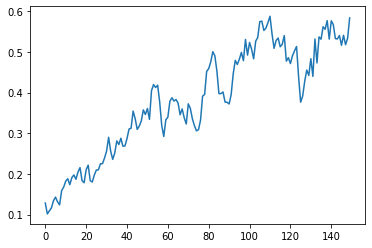

In [91]:
plt.plot(history.history['iou'])

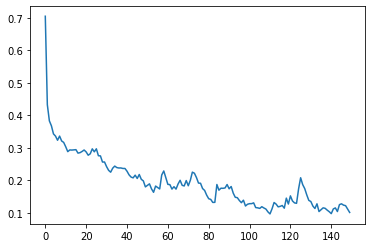

In [92]:
plt.plot(history.history['loss'])

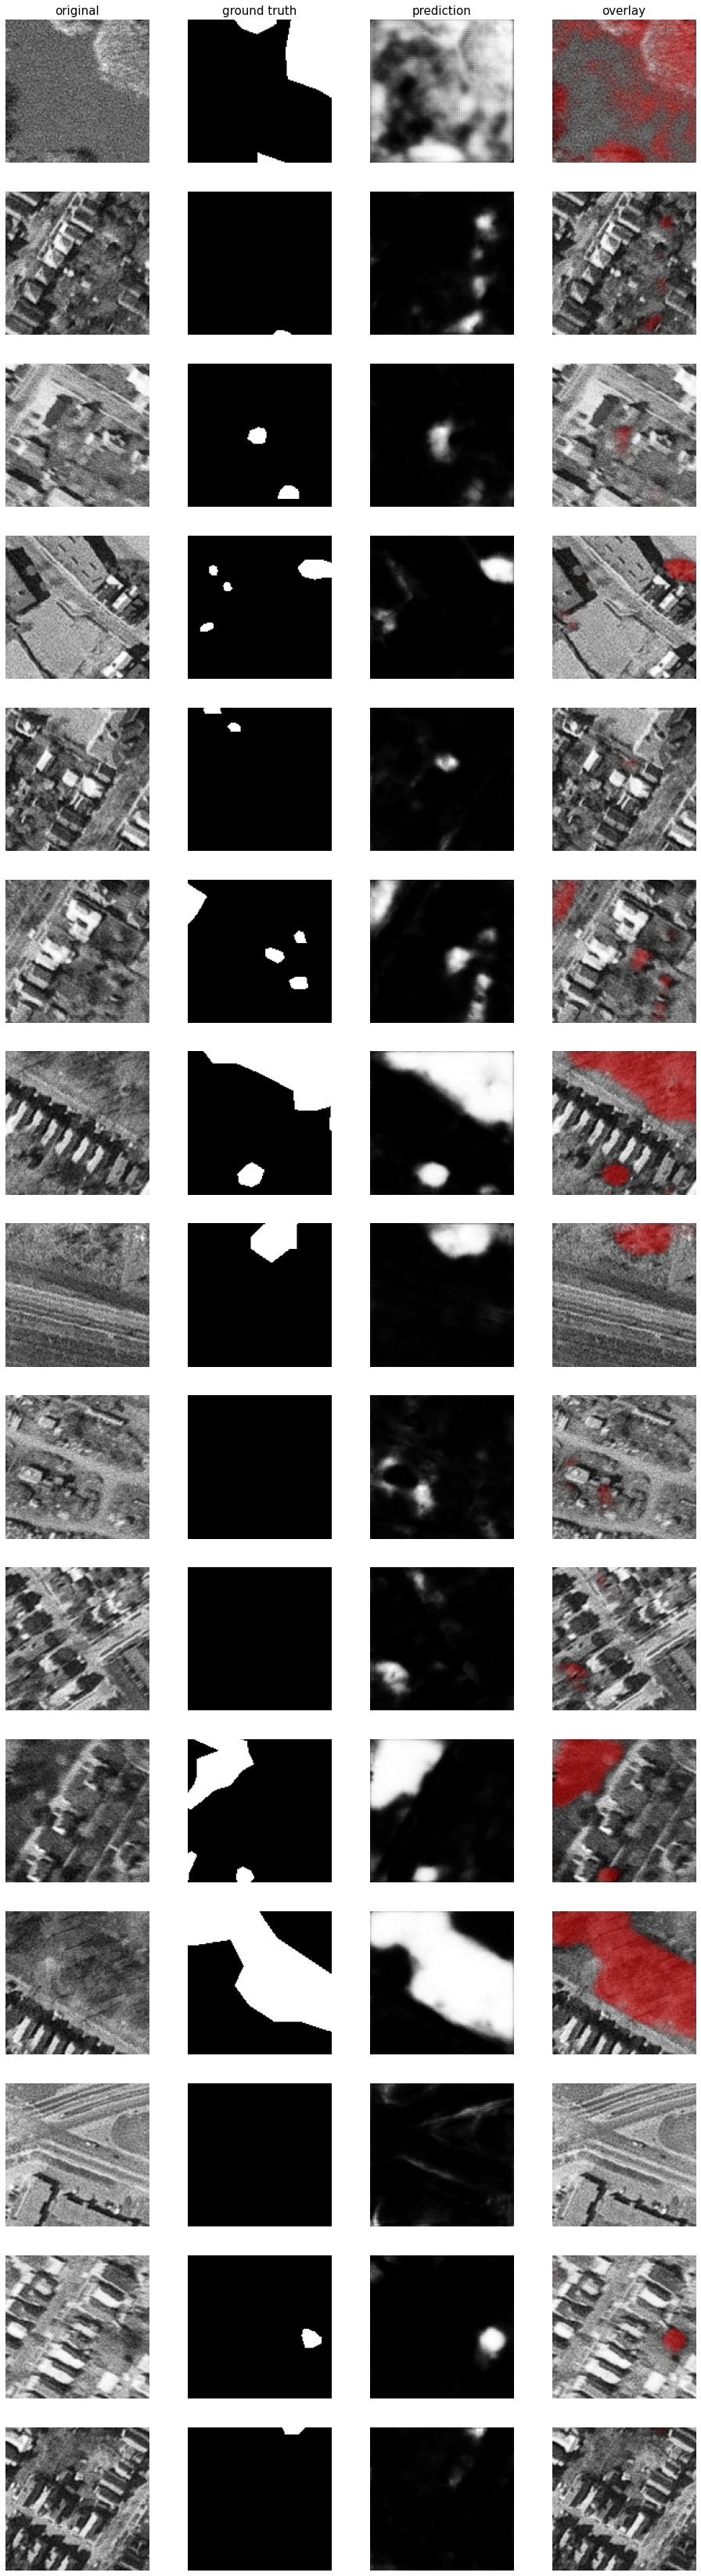

In [93]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(W, N, M, 1), 
    mask_imgs=Y[:, :, :, 0], 
    pred_imgs=Y_pred[:, :, :, 0], 
    nm_img_to_plot=15
  )

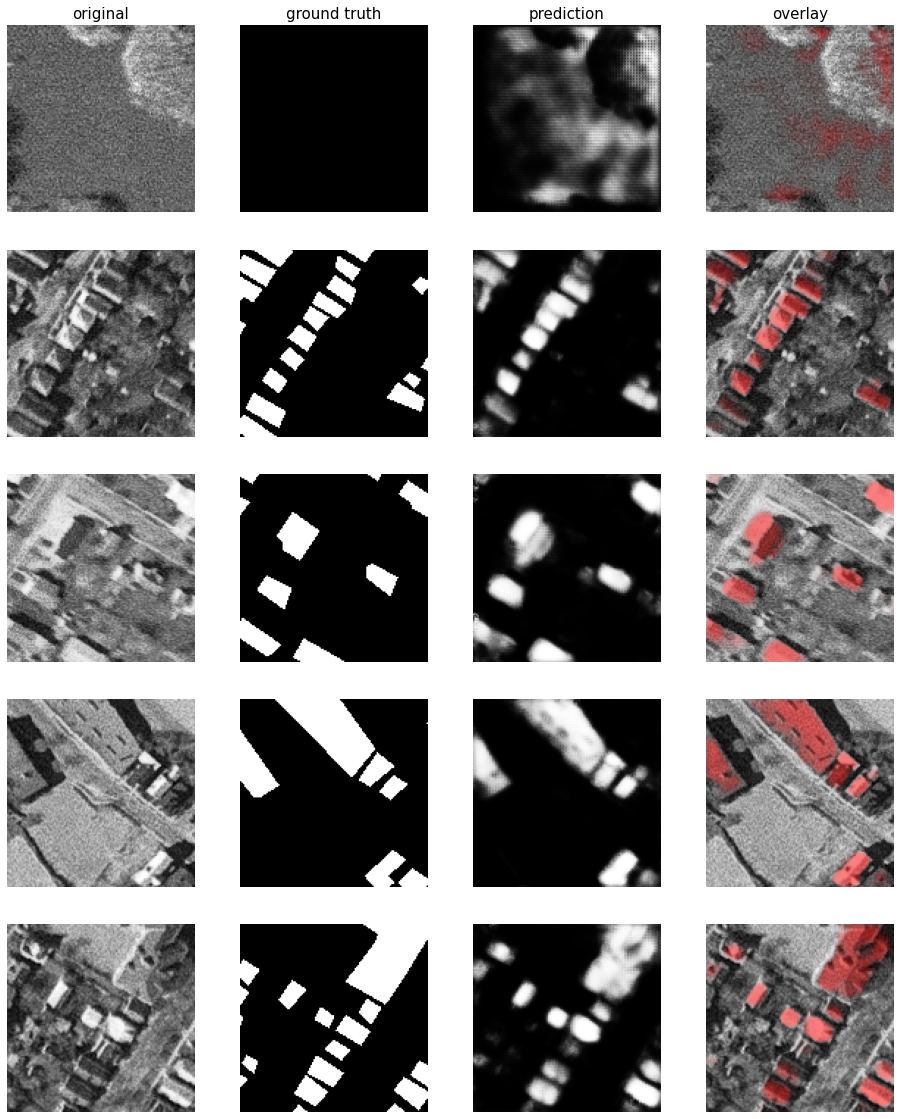

In [94]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(W, N, M, 1), 
    mask_imgs=Y[:, :, :, 1], 
    pred_imgs=Y_pred[:, :, :, 1], 
    nm_img_to_plot=5
  )

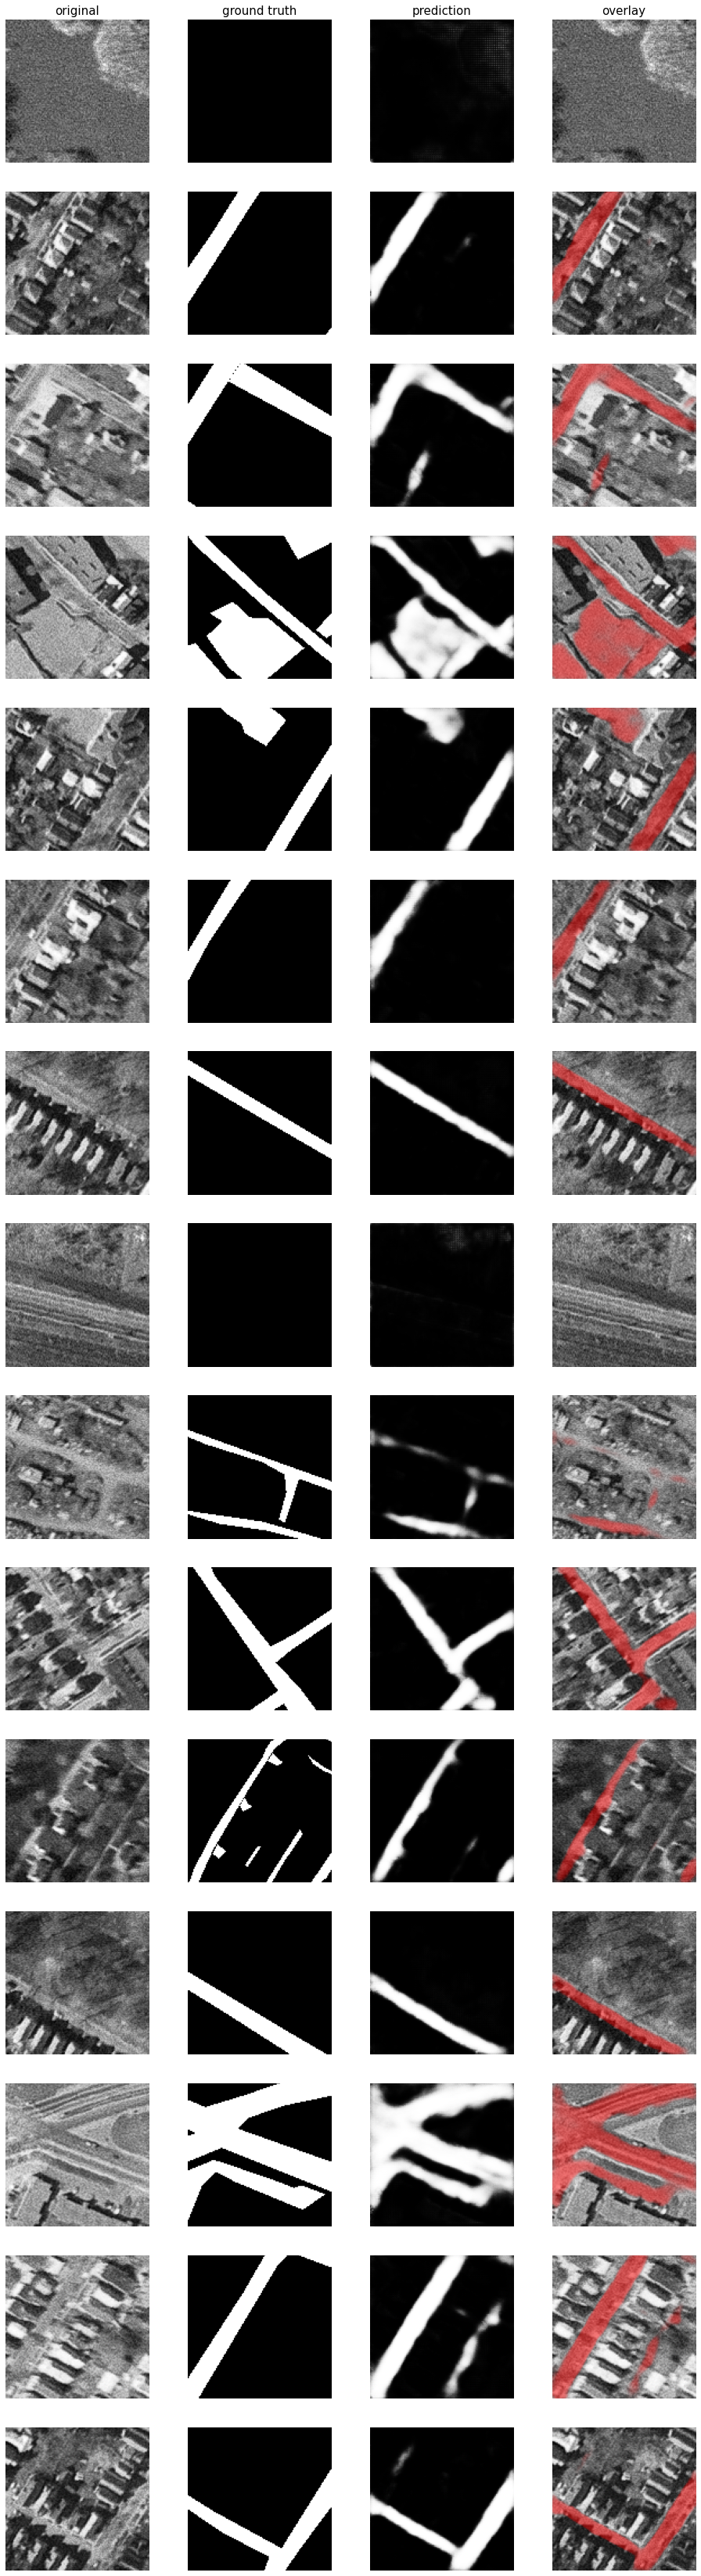

In [95]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(W, N, M, 1), 
    mask_imgs=Y[:, :, :, 2], 
    pred_imgs=Y_pred[:, :, :, 2], 
    nm_img_to_plot=15
  )

In [96]:
# validation data
base_dir = Path(r'e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid')
mask_dirV = base_dir.joinpath('mask_80s_valid')
train_image_dirV = mask_dirV.joinpath('u_valid_reproject')
trees_mask_dirV = mask_dirV.joinpath('trees')
building_mask_dirV = mask_dirV.joinpath('building')
pavement_mask_dirV = mask_dirV.joinpath('pavement')

In [97]:
K = 20

In [98]:
valid_images = load_stack_safely_large((K, N, M), np.float32, train_image_dirV, "wgs_valid")
tree_valid = load_stack_safely_large((K, N, M), np.int8, trees_mask_dirV, "tree_mask")
building_valid = load_stack_safely_large((K, N, M), np.int8, building_mask_dirV, "building_mask")
pavement_valid = load_stack_safely_large((K, N, M), np.int8, pavement_mask_dirV, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_50s_valid\u_valid_reproject\wgs_valid_1.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_50s_valid\u_valid_reproject\wgs_valid_2.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_50s_valid\u_valid_reproject\wgs_valid_3.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_50s_valid\u_valid_reproject\wgs_valid_4.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_50s_valid\u_valid_reproject\wgs_valid_5.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_50s_valid\u_valid_reproject\wgs_valid_6.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_50s_valid\u_valid_reproject\wgs_valid_7.tif
skipping e:\Google Drive\research\projects\utica\model_save\1980\data_256\valid\mask_50s_valid\u_

In [50]:
Yvalid = np.zeros(shape=(K, N, M, 3), dtype=np.int8)
Yvalid[:, :, :, 0] = tree_valid
Yvalid[:, :, :, 1] = building_valid
Yvalid[:, :, :, 2] = pavement_valid

In [51]:
Y_valid = model.predict(valid_images.reshape(K, N, M, 1))

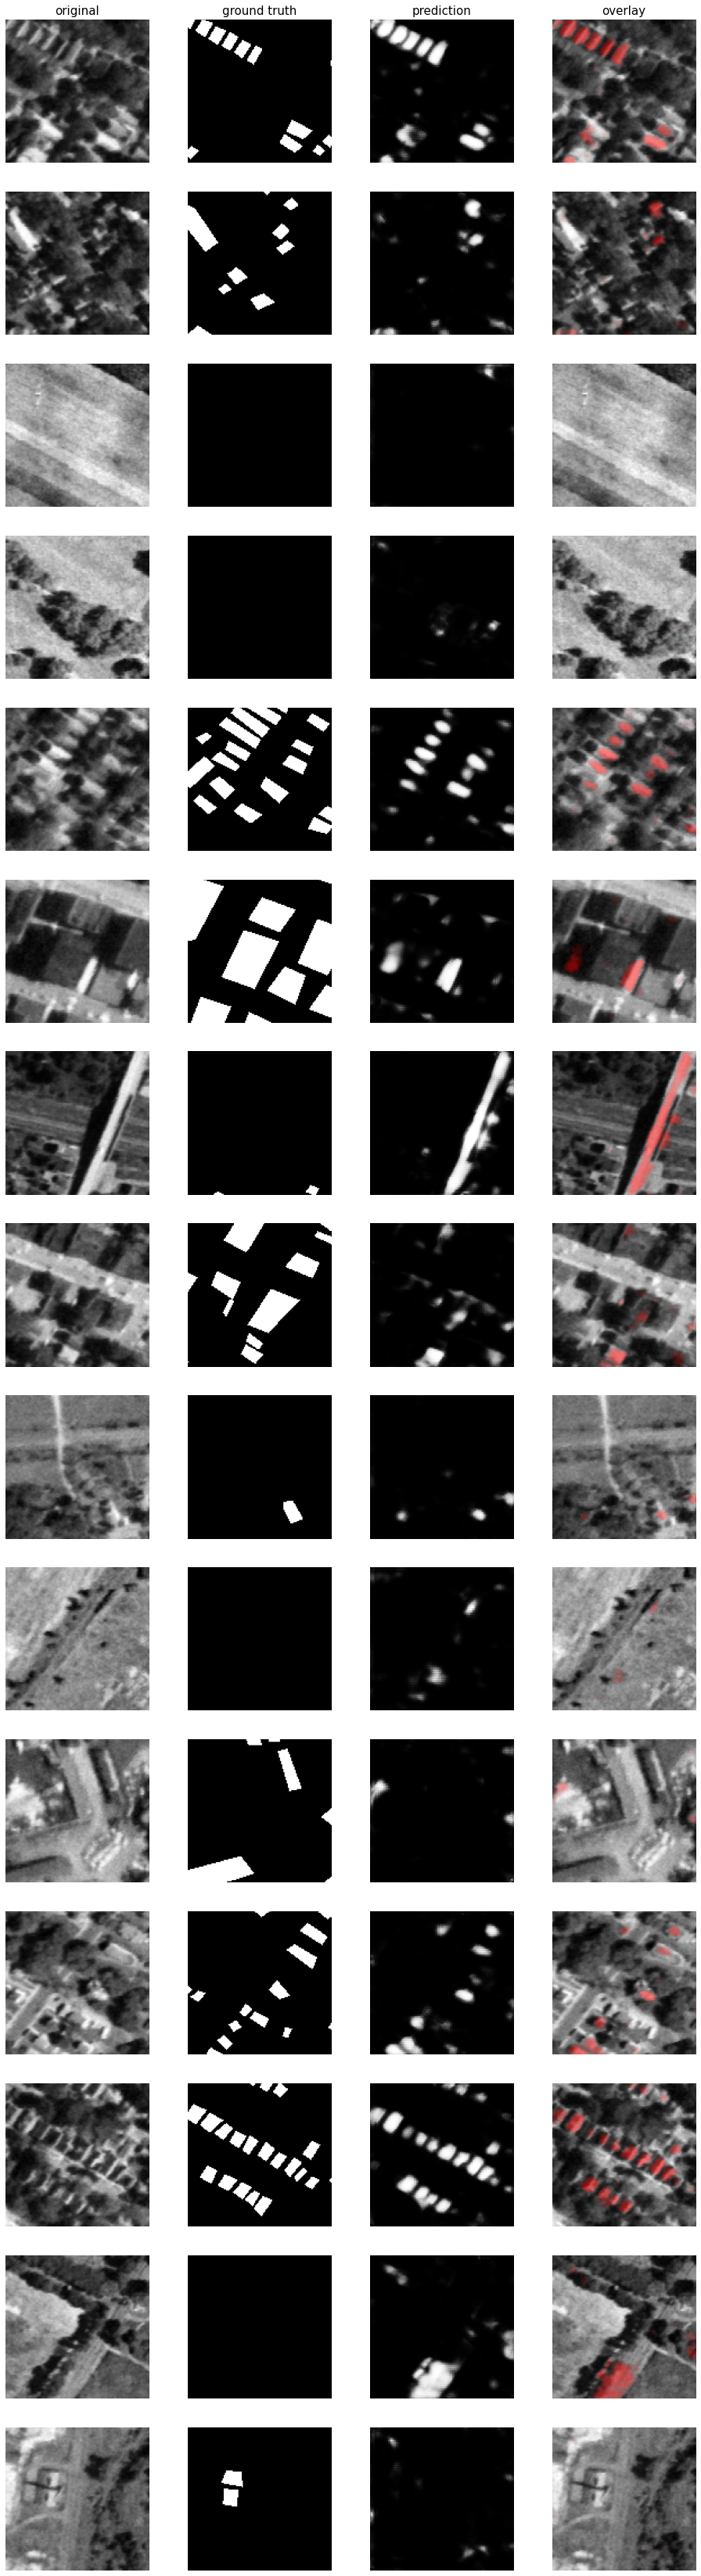

In [52]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 1), 
    mask_imgs=Yvalid[:, :, :, 1], 
    pred_imgs=Y_valid[:, :, :, 1], 
    nm_img_to_plot=15
  )

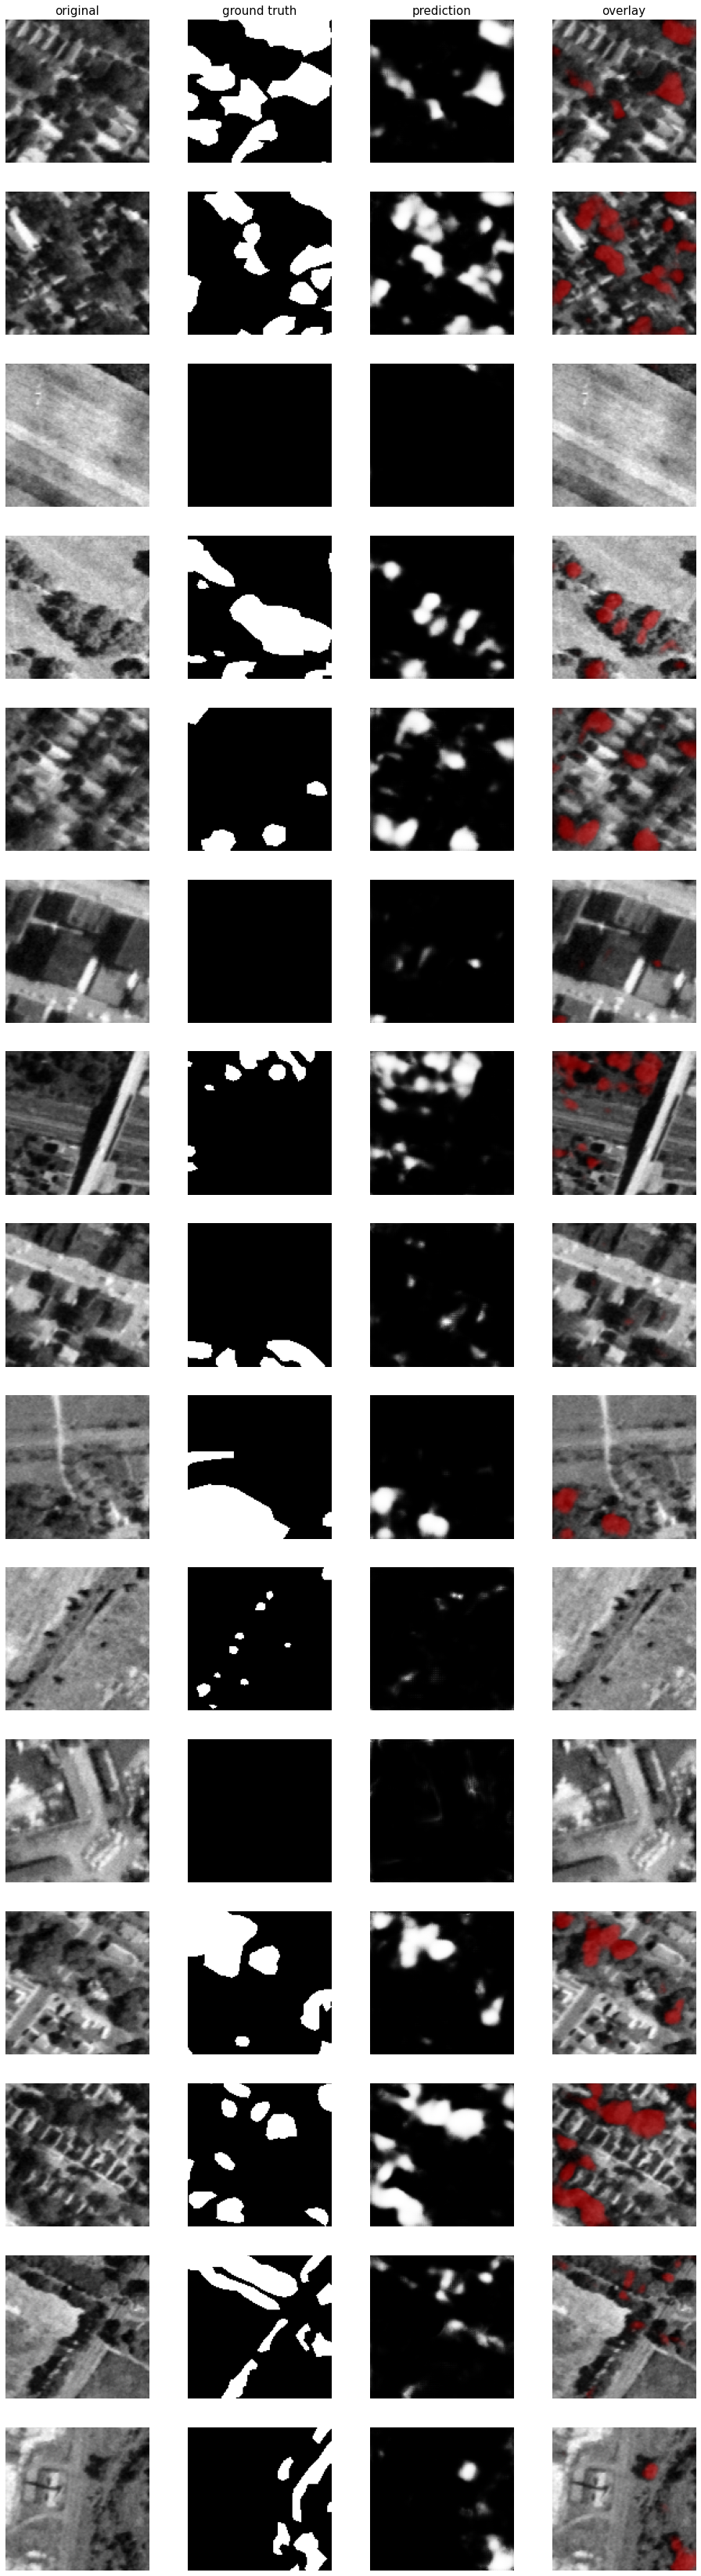

In [53]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 1), 
    mask_imgs=Yvalid[:, :, :, 0], 
    pred_imgs=Y_valid[:, :, :, 0], 
    nm_img_to_plot=15
  )

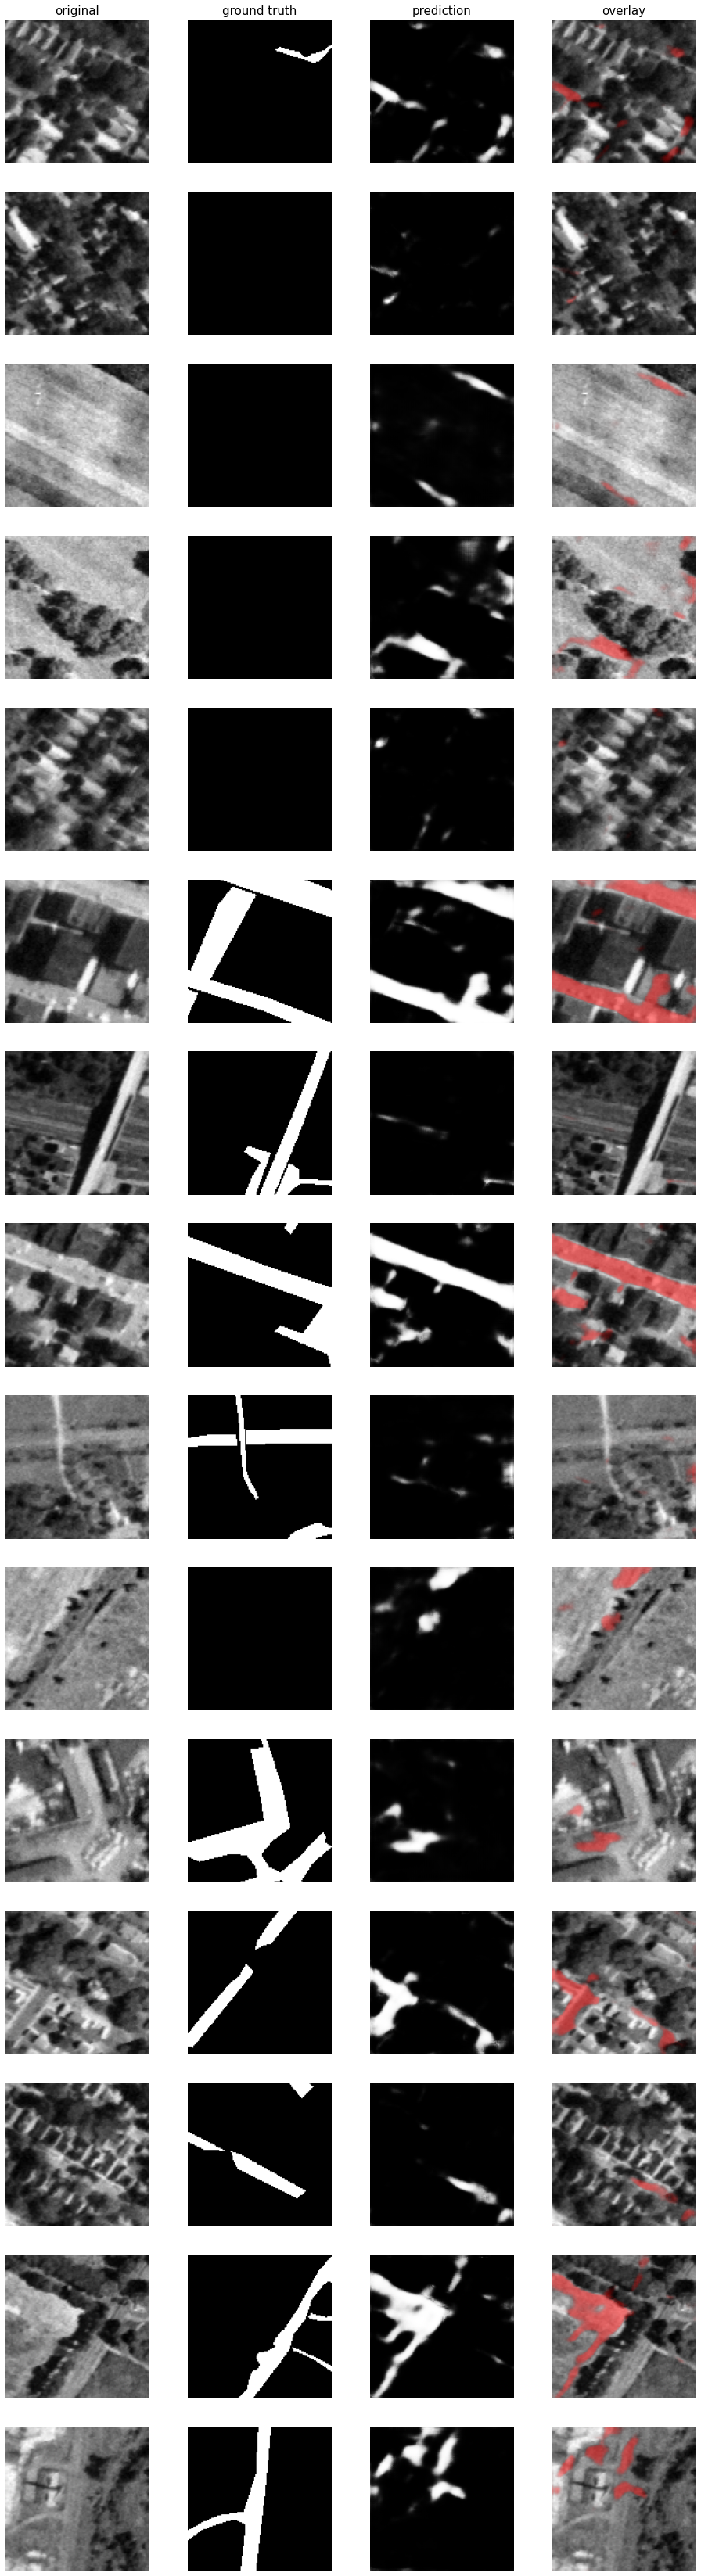

In [54]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 1), 
    mask_imgs=Yvalid[:, :, :, 2], 
    pred_imgs=Y_valid[:, :, :, 2], 
    nm_img_to_plot=15
  )

In [55]:
Y_valid[0,0,0,0]

0.019601285

In [56]:
treePredict = Y_valid[:,:,:,0]

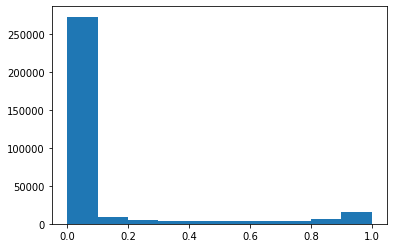

In [57]:
plt.hist(treePredict.flatten())
plt.show()

In [58]:
valid_orig = gdal.Open(r'e:\Google Drive\research\projects\utica\model_save\1950\data_256\valid\mask_50s_valid\u_valid_reproject\wgs_valid_1.tif')

In [59]:
gt = valid_orig.GetGeoTransform()
pt = valid_orig.GetProjection()

In [60]:
driver = gdal.GetDriverByName("GTiff")

In [61]:
driver.Register()

2

In [62]:
outds = driver.Create(r'e:\Google Drive\research\projects\utica\50s_valid_out\valid_out.tif', xsize=256,ysize=256,
                     bands=1,eType=gdal.GDT_Float32)

In [63]:
outds.SetGeoTransform(gt)

0

In [64]:
outds.SetProjection(pt)

0

In [65]:
outBand = outds.GetRasterBand(1)

In [66]:
outBand.WriteArray(Y_valid[1,:,:,0])

0

In [67]:
outBand.SetNoDataValue(np.nan)

0

In [68]:
outBand.FlushCache()

In [69]:
outBand = None
outds = None

In [70]:
make_path(img_dir, prefix, i + 1,.tif)

SyntaxError: invalid syntax (Temp/ipykernel_25024/1186116247.py, line 1)

In [71]:
def load_stack_nt(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape=shape, dtype=dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        stack[i, :, :] = load_image_no_trim(image_path)
    return stack

In [72]:
def save_predict_valid( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTree = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTree.SetGeoTransform(gt)
        outTree.SetProjection(pt)
        outBandTree = outTree.GetRasterBand(1)
        outBandTree.WriteArray(Y_valid[i,:,:,0])
        outBandTree.SetNoDataValue(np.nan)
        outBandTree.FlushCache()
        outBandTree = None
        outTree = None

In [73]:
tree_valid_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\valid\tree'
save_predict_valid(nImg = 20,xdim= 128, ydim= 128,img_dir = tree_valid_dir,prefix = "tree_predict",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [74]:
def save_predict_validB( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        build_ds = gdal.Open(orig_path)
        gt = build_ds.GetGeoTransform()
        pt = build_ds.GetProjection()
        outBuild = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outBuild.SetGeoTransform(gt)
        outBuild.SetProjection(pt)
        outBandBuild = outBuild.GetRasterBand(1)
        outBandBuild.WriteArray(Y_valid[i,:,:,1])
        outBandBuild.SetNoDataValue(np.nan)
        outBandBuild.FlushCache()
        outBandBuild = None
        outBuild = None

In [75]:
build_valid_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\valid\building'
save_predict_validB(nImg = 20,xdim= 128, ydim= 128,img_dir =build_valid_dir,prefix = "building_predict",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [76]:
def save_predict_validP( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        build_ds = gdal.Open(orig_path)
        gt = build_ds.GetGeoTransform()
        pt = build_ds.GetProjection()
        outPave = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outPave.SetGeoTransform(gt)
        outPave.SetProjection(pt)
        outBandPave = outPave.GetRasterBand(1)
        outBandPave.WriteArray(Y_valid[i,:,:,2])
        outBandPave.SetNoDataValue(np.nan)
        outBandPave.FlushCache()
        outBandPave = None
        outPave = None

In [77]:
pave_valid_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\valid\pavement'
save_predict_validP(nImg = 20,xdim= 128, ydim= 128,img_dir =pave_valid_dir,prefix = "pavement_predict",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [78]:
#due to late night coding, mask files where slightly off dimensions. Need to resave files that were cut down here for easier matching.
def save_mask_valid( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [79]:
tree_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\data_128\crop_valid\tree'
save_mask_valid(nImg = 20,xdim= 128, ydim= 128,img_dir = tree_m_dir, prefix = "tree_mask",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [80]:
def save_mask_validB( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [81]:
build_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\data_128\crop_valid\building'
save_mask_validB(nImg = 20,xdim= 128, ydim= 128,img_dir = build_m_dir, prefix = "building_mask",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [82]:
def save_mask_validP( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Yvalid[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [83]:
pave_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\data_128\crop_valid\pavement'
save_mask_validP(nImg = 20,xdim= 128, ydim= 128,img_dir = pave_m_dir, prefix = "pavement_mask",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [84]:
def save_mask_image( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(valid_images[i, :, :])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [85]:
image_m_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\data_128\crop_valid\image'
save_mask_image(nImg = 20,xdim= 128, ydim= 128,img_dir = image_m_dir, prefix = "image",orig_dir = train_image_dirV , prefix_orig = "wgs_valid")

In [86]:
valid_images.shape

(20, 128, 128)

In [88]:
# prediction data
base_dirP = Path(r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\image')

In [89]:
J, N, M = 1740, 128, 128

In [90]:
predict_img = load_stack_nt((J, N, M), np.float32,base_dirP, "predict")

In [91]:
Y_all = model.predict(predict_img.reshape(J, N, M, 1))

In [92]:
# prediction data offset 2 (25 pixels)
base_dirP2 = Path(r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\image_2')
predict_img2 = load_stack_nt((J, N, M), np.float32,base_dirP2, "predict")

In [93]:
Y_all2 = model.predict(predict_img2.reshape(J, N, M, 1))

In [95]:
# prediction data offset 3 (100 pixels)
L, N, M = 1653, 128, 128
base_dirP3 = Path(r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\image_3')
predict_img3 = load_stack_nt((L, N, M), np.float32,base_dirP3, "predict")

In [102]:
Y_all3 = model.predict(predict_img3.reshape(L, N, M, 1))
Y_all3.shape

(1653, 128, 128, 3)

In [97]:
# save map prediction

def save_predict_build( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None


predict_build_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\out\image\building'
save_predict_build(nImg = 1740,xdim= 128, ydim= 128,img_dir = predict_build_dir, prefix = "building",orig_dir = base_dirP , prefix_orig = "predict")

In [100]:
# save map prediction

def save_predict_build2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None


predict_build_dir2 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\out\image_2\building'
save_predict_build2(nImg = 1740,xdim= 128, ydim= 128,img_dir = predict_build_dir2, prefix = "building",orig_dir = base_dirP2 , prefix_orig = "predict")

In [103]:
# save map prediction

def save_predict_build3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 1])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None


predict_build_dir3 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\out\image_3\building'
save_predict_build3(nImg = 1653,xdim= 128, ydim= 128,img_dir = predict_build_dir3, prefix = "building",orig_dir = base_dirP3 , prefix_orig = "predict")

In [104]:
def save_predict_tree( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_tree_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\out\image\tree'
save_predict_tree(nImg = 1740,xdim= 128, ydim= 128,img_dir = predict_tree_dir, prefix = "tree",orig_dir = base_dirP , prefix_orig = "predict")

In [105]:
def save_predict_tree2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_tree_dir2 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\out\image_2\tree'
save_predict_tree2(nImg = 1740,xdim= 128, ydim= 128,img_dir = predict_tree_dir2, prefix = "tree",orig_dir = base_dirP2 , prefix_orig = "predict")

In [106]:
def save_predict_tree3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_tree_dir3 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\out\image_3\tree'
save_predict_tree3(nImg = 1653,xdim= 128, ydim= 128,img_dir = predict_tree_dir3, prefix = "tree",orig_dir = base_dirP3 , prefix_orig = "predict")

In [107]:
def save_predict_pave( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_pave_dir = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\out\image\pavement'
save_predict_pave(nImg = 1740,xdim= 128, ydim= 128,img_dir = predict_pave_dir, prefix = "pavement",orig_dir = base_dirP , prefix_orig = "predict")

In [108]:
def save_predict_pave2( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all2[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_pave_dir2 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\out\image_2\pavement'
save_predict_pave2(nImg = 1740,xdim= 128, ydim= 128,img_dir = predict_pave_dir2, prefix = "pavement",orig_dir = base_dirP2 , prefix_orig = "predict")

In [110]:
def save_predict_pave3( nImg, xdim,ydim, img_dir, prefix, orig_dir, prefix_orig):
    for i in range(nImg):
        image_path = make_path(img_dir, prefix, i + 1)
        orig_path = make_path(orig_dir, prefix_orig, i + 1) 
        orig_ds = gdal.Open(orig_path)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(Y_all3[i, :, :, 2])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None
        
predict_pave_dir3 = r'e:\Google Drive\research\projects\utica\model_save\1950\prediction_128\out\image_3\pavement'
save_predict_pave3(nImg = 1653,xdim= 128, ydim= 128,img_dir = predict_pave_dir3, prefix = "pavement",orig_dir = base_dirP3 , prefix_orig = "predict")